In [2]:
# default_exp core

In [1]:
#hide
%load_ext autoreload
%autoreload 2
from nbdev.showdoc import *

In [ ]:
#export
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt

import logging
logger = logging.getLogger(__name__)

from sklearn.preprocessing import StandardScaler

# Dimension Reduction

> The function performs dimensionality reduction, pre-processing the data and comparing the reconstruction error via PCA and autoencoder.

Reference: 
- https://towardsdatascience.com/dimensionality-reduction-pca-versus-autoencoders-338fcaf3297d
- https://towardsdatascience.com/autoencoders-vs-pca-when-to-use-which-73de063f5d7

In [296]:
#export
class dimensionReducer:
    
    def __init__(self, input_data, reduce_dim, learning_rate = 0.005):
        """
        Intialize the dimension reducer
        : param input_data: (pd.DataFrame or numpy.ndarray) An input data that will be used for dimension reduction
        : param reduce_dim: Number of the output's dimension (reduced dimension)
        : param learning_rate: the learning rate for the Adam optimization during the autoencoder model fitting
        : return None
        """
        self.reduce_dim = reduce_dim
        self.X = input_data
        self.learning_rate = learning_rate
        return None
    
    def validateInputs(self):
        """
        Validating the input
        : is it pd.DataFrame or numpy.ndarray?
        : any missing data/NaN/null?
        """
        if (type(analyzer.embeddingRaw) != np.ndarray) or (type(analyzer.embeddingRaw) != pd.core.frame.DataFrame) :
            return True
        else:
            raise ValueError('Incorrect input type: the input must be either numpy.ndarray or pandas.DataFrame')
            
    
    def fit(self):
        """
        Fit Transform PCA and Autoencoder
        """
        
        if (self.validateInputs()):
            
            ### Standardization 
            # StandardScaler: this is necessary since PC's are obtained by maximizing the variation within the data. 
            # sklearn.preprocessing.StandardScaler - z = (x - u) / s
            # Why Scaling instead of normalizing? 
            # - https://stats.stackexchange.com/questions/385775/normalizing-vs-scaling-before-pca
            # - https://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html
            scaler = StandardScaler()
            X_scale = scaler.fit_transform(self.X)
            self.X_scale = X_scale

            ### Fitting PCA
            self.X_PCA_reconstruct, self.dfLowDimPCA = fitting_PCA(X_scale, self.reduce_dim)

            ### Fitting 1-layer AutoEncoder
            self.X_1AE_reconstruct, self.dfLowDim1AE, self.model1AE, self.hist1AE = fitting_1layer_encoder(X_scale, self.reduce_dim, self.learning_rate)
            
            ### Fitting 2-layer AutoEncoder
            self.X_2AE_reconstruct, self.dfLowDim2AE, self.model2AE, self.hist2AE = fitting_2layer_encoder(X_scale, self.reduce_dim, self.learning_rate)
            
            
            rmse_PCA = calculate_rmse(X_scale, self.X_PCA_reconstruct)
            rmse_1AE = calculate_rmse(X_scale, self.X_1AE_reconstruct)
            rmse_2AE = calculate_rmse(X_scale, self.X_2AE_reconstruct)
            self.rmse_result = pd.DataFrame({"PCA":rmse_PCA, "1AE": rmse_1AE, "2AE":rmse_2AE}, index=["MSE"])
            
            return None
        
        
    def plot_autoencoder_performance(self):
        
        hist1 = self.hist1AE
        plt.figure(figsize=(8, 4))
        plt.plot(hist1.history['loss'])
        plt.plot(hist1.history['val_loss'])
        plt.title('Model 1-layer AE: loss')
        plt.ylabel('loss'); plt.xlabel('epoch')
        plt.legend(['Training_MSE', 'Validation_MSE'], loc='upper right')
        
        hist2 = self.hist2AE
        plt.figure(figsize=(8, 4))
        plt.plot(hist2.history['loss'])
        plt.plot(hist2.history['val_loss'])
        plt.title('Model 2-layer AE: loss')
        plt.ylabel('loss'); plt.xlabel('epoch')
        plt.legend(['Training_MSE', 'Validation_MSE'], loc='upper right')
        

***

### Fitting PCA function

In [268]:
#export
from sklearn.decomposition import PCA

def fitting_PCA(X, reduce_dim):
                 
    pca = PCA(n_components=reduce_dim)
    X_PCA_transform = pca.fit_transform(X)
    X_PCA_reconstruct = pca.inverse_transform(X_PCA_transform)
    dfLowDimPCA = pd.DataFrame(data = X_PCA_transform, columns=list(range(X_PCA_transform.shape[1])))
    
    return X_PCA_reconstruct, dfLowDimPCA

***

### Fitting 1-layer Autoencoder function

In [239]:
#export
from keras.layers import Input, Dense
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import Adam

In [267]:
#export
def fitting_1layer_encoder(X, reduce_dim, learning_rate):

    in_out_dimension = X.shape[1]

    # Model Construction
    input_layer = Input(shape=(in_out_dimension,))
    encoded = Dense(reduce_dim, activation='linear')(input_layer)
    decoded = Dense(in_out_dimension, activation=None)(encoded)

    # Autoencoder Model
    autoencoder = Model(input_layer, decoded)
    encoder = Model(input_layer, encoded)

    # Compiling the model
    autoencoder.compile(optimizer=Adam(lr=learning_rate), loss='mean_squared_error')

    # Fitting the model
    history = autoencoder.fit(X, X, epochs=1000, batch_size=32, shuffle=True, verbose=0, validation_split=0.2
                              , callbacks = [EarlyStopping(monitor='val_loss', patience=50)
                                             ,ModelCheckpoint(filepath='best_model.h5'
                                                              , monitor='val_loss'
                                                              , save_best_only=True)])

    # output: reduced dimension data and reconstruction data
    encoded_dim = encoder.predict(X)
    dfLowDim1AE = pd.DataFrame(data = encoded_dim, columns=list(range(encoded_dim.shape[1])))
    decoded_dim = autoencoder.predict(X)
    

    return decoded_dim, dfLowDim1AE, autoencoder, history

In [247]:
autoencoder.summary()

Model: "model_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        [(None, 768)]             0         
_________________________________________________________________
dense_34 (Dense)             (None, 2)                 1538      
_________________________________________________________________
dense_35 (Dense)             (None, 768)               2304      
Total params: 3,842
Trainable params: 3,842
Non-trainable params: 0
_________________________________________________________________


***

### Fitting 2-layer Autoencoder function

In [266]:
#export
def fitting_2layer_encoder(X, reduce_dim, learning_rate):

    in_out_dimension = X.shape[1]
    half_dimension = (in_out_dimension - reduce_dim) / 2
    
    # Model Construction
    input_layer = Input(shape=(in_out_dimension,))
    encoded1 = Dense(half_dimension, activation='relu')(input_layer)
    encoded2 = Dense(reduce_dim, activation='relu')(encoded1)
    decoded1 = Dense(half_dimension, activation='relu')(encoded2)
    decoded2 = Dense(in_out_dimension, activation=None)(decoded1)

    # Autoencoder Model
    autoencoder = Model(input_layer, decoded2)
    encoder = Model(input_layer, encoded2)

    # Compiling the model
    autoencoder.compile(optimizer=Adam(lr=learning_rate), loss='mean_squared_error')

    # Fitting the model
    history = autoencoder.fit(X, X, epochs=1000, batch_size=32, shuffle=True, verbose=0, validation_split=0.2
                              , callbacks = [EarlyStopping(monitor='val_loss', patience=50)
                                             ,ModelCheckpoint(filepath='best_model.h5'
                                                              , monitor='val_loss'
                                                              , save_best_only=True)])

    # output: reduced dimension data and reconstruction data
    encoded_dim = encoder.predict(X)
    dfLowDim2AE = pd.DataFrame(data = encoded_dim, columns=list(range(encoded_dim.shape[1])))
    decoded_dim = autoencoder.predict(X)

    return decoded_dim, dfLowDim2AE, autoencoder, history

In [243]:
autoencoder.summary()

Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 768)]             0         
_________________________________________________________________
dense_2 (Dense)              (None, 383)               294527    
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 768       
_________________________________________________________________
dense_4 (Dense)              (None, 383)               1149      
_________________________________________________________________
dense_5 (Dense)              (None, 768)               294912    
Total params: 591,356
Trainable params: 591,356
Non-trainable params: 0
_________________________________________________________________


***

### RMSE Function
Let $X = <\vec x_1, ..., \vec x_n>$ be a $n \times m$ matrix and 

Let $Y = <\vec y_1, ..., \vec y_n>$ be a $n \times m$ matrix.

Then the Root Mean Squared Error (RMSE) is defined as follow:

$$MSE = {\frac{\sum_i^n (\|\vec x_i - \vec y_i\|_2)^2}{n \times m}}
= {\frac{\sum_i^n \sum_j^m (x_{i_j} - y_{i_j})^2}{n \times m}}$$.

Reference: https://stats.stackexchange.com/questions/69333/rmse-mad-of-vectors

In [270]:
#export
def calculate_rmse(np_arr1, np_arr2):
    """ Calculating the Root Mean Squared Error"""
    return ((((np_arr1 - np_arr2)**2).sum()) / (np_arr1.shape[0] * np_arr1.shape[1]) )

***

### Plotting the output (for 2-dimensional embedding)

In [302]:
def plot_output(df):
        """
        Visualize the output.
        """
        if (len(df.columns) != 2):
            raise ValueError("The embedding must be 2-dimensional vectors.") 
        ### Plotting KMeans
        plt.figure(figsize=(8, 8))
        plt.scatter(df[0], df[1])
        plt.title("2D Projection of the data")

***

# Example

**Input data:**
The input matrix has a size of 863 $\times$ 768.

In [283]:
import pickle

with open('testing_data.pickle', 'rb') as handle:
    testing_data = pickle.load(handle)
    
print ("Data's size: ", testing_data.shape)
print ("Dimension:   ", testing_data.shape[1])

Data's size:  (863, 768)
Dimension:    768


**Performing dimension reduction:** we will reduce the number of dimension from 768 to 2. 

In [271]:
dim_reducer = dimensionReducer(analyzer.embeddingRaw, 2, 0.002)
dim_reducer.fit()

**Calculating the MSE of the reconstructed vectors**

In [277]:
dim_reducer.rmse_result

,PCA,1AE,2AE
MSE,0.740122,0.741237,0.641363


Here we can see that the two-layers autoencoder has the best performance with the lowest MSE of 0.64.

**Observing the loss thorughout the epoch:** If we see that the MSE doesn't converge fast enough, we could adjust the learning rate parameter. The default is 0.002. Try increase it to 0.005 if it doesn't converge or decrease to 0.001 if it converges way too fast and oscillating.

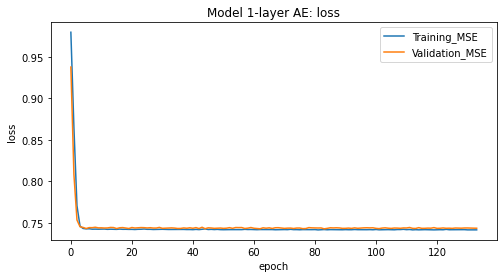

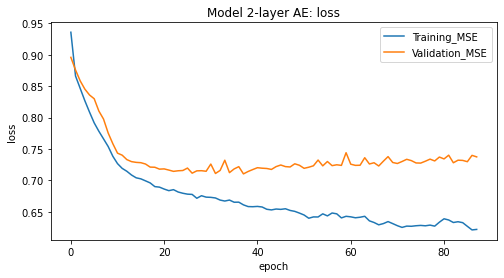

In [276]:
dim_reducer.plot_autoencoder_performance()

**Reduced Dimension Output:** There are three outputs from three different methods, which are PCA, 1-layer AE, and 2-layers AE.

In [273]:
dim_reducer.dfLowDimPCA.head()

,0,1
0,-16.078735,-6.701482
1,-8.858161,9.354184
2,4.305742,-0.464687
3,-11.514315,-0.687469
4,1.212007,6.537956


In [274]:
dim_reducer.dfLowDim1AE.head()

,0,1
0,2.658184,6.454404
1,-3.722385,3.450950
2,-0.186975,-1.620856
3,0.364970,4.719998
4,-2.843418,-0.903326


In [275]:
dim_reducer.dfLowDim2AE.head()

,0,1
0,1.188639,12.213808
1,24.526394,29.610954
2,11.857518,6.406322
3,0.000000,9.951591
4,16.653738,30.677238


**Plotting the embedding (for 2-dimensional embedding)**

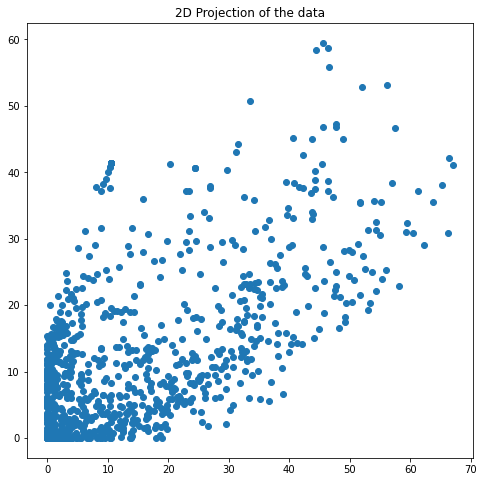

In [291]:
plot_output(dim_reducer.dfLowDim2AE)

***

## Updating the library without nbdev_build_lib

In [297]:
from nbdev.export import notebook2script; notebook2script()

Converted 00_dimensionReducer.ipynb.
Converted index.ipynb.
